Importing pre trained DETR_resnet50 model via PyTorch Hub

Importing Torch library and other necessary packages

In [ ]:
import torch as th
import requests
from matplotlib import pyplot as plt 

In [ ]:
from PIL import Image
import torchvision.transforms as T

Importing model an performing valuation to confirm its presence

In [ ]:
model=th.hub.load("facebookresearch/detr","detr_resnet50",pretrained=True)
model.eval()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

Example to execute the model using torch

Creating a copy of image to generate output

In [ ]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [ ]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return th.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * th.tensor([img_w, img_h, img_w, img_h], dtype=th.float32)
    return b

In [ ]:
def detect(im, model, transform, prob):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    with th.no_grad():
        outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > prob

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], (800, 600))
    return probas[keep], bboxes_scaled

In [ ]:
url="https://imgs.search.brave.com/4qK5afHPlAhMZOX_S1tUMS0iuHsBSy_S8hIVbIzax94/rs:fit:880:880:1/g:ce/aHR0cHM6Ly90aGVh/d2Vzb21lZGFpbHku/Y29tL3dwLWNvbnRl/bnQvdXBsb2Fkcy8y/MDE3LzEyL3R3by1k/b2dzLWFuZC1hLWNh/dC1waG90b3MtMS0x/LmpwZw"

In [ ]:
# Image source: https://www.pexels.com/photo/cute-dogs-lying-on-the-porch-with-a-laptop-notebook-and-pen-9040620/
# img author: Alena Darmel
img=Image.open("pexels-alena-darmel-9040620.jpg")
img.size

(3000, 4500)

In [ ]:
img2=img.copy().resize((800,600))
img2.size

(800, 600)

In [ ]:
scores, boxes = detect(img, model, transform, 0.93)

Output Generation

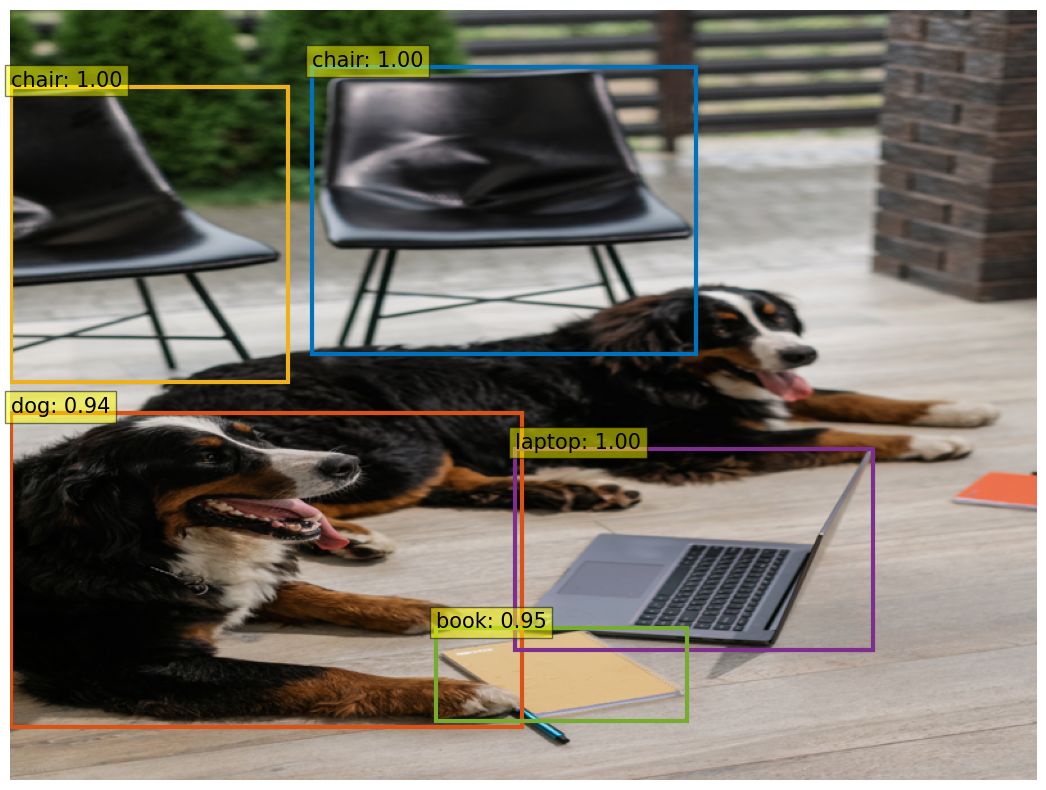

In [ ]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
plot_results(img2, scores, boxes)

Generation of ONNX model

ONNX (Open Neural Network Exchange) is an open format for ML models. It allows you to easily interchange models between various ML frameworks and tools.

You can export a neural network from the following Deep Learning APIs:
* Pytorch
* Tensorflow
* Keras

It is easy to export a Pytorch model to ONNX because it is built into the API. The [Pytorch documentation](https://pytorch.org/docs/stable/onnx.html) provides a good example on how to perform this conversion.

In [ ]:
help(th.onnx.export) # function used to conert model to its onnx couterpart

Help on function export in module torch.onnx.utils:

export(model: 'Union[torch.nn.Module, torch.jit.ScriptModule, torch.jit.ScriptFunction]', args: 'Union[Tuple[Any, ...], torch.Tensor]', f: 'Union[str, io.BytesIO]', export_params: 'bool' = True, verbose: 'bool' = False, training: '_C_onnx.TrainingMode' = <TrainingMode.EVAL: 0>, input_names: 'Optional[Sequence[str]]' = None, output_names: 'Optional[Sequence[str]]' = None, operator_export_type: '_C_onnx.OperatorExportTypes' = <OperatorExportTypes.ONNX: 0>, opset_version: 'Optional[int]' = None, do_constant_folding: 'bool' = True, dynamic_axes: 'Optional[Union[Mapping[str, Mapping[int, str]], Mapping[str, Sequence[int]]]]' = None, keep_initializers_as_inputs: 'Optional[bool]' = None, custom_opsets: 'Optional[Mapping[str, int]]' = None, export_modules_as_functions: 'Union[bool, Collection[Type[torch.nn.Module]]]' = False) -> 'None'
    Exports a model into ONNX format.
    
    If ``model`` is not a :class:`torch.jit.ScriptModule` nor a


Installing necessary packages

In [ ]:
!pip install -Iv protobuf==3.20.2
!pip install onnxruntime
!pip install onnx

Using pip 22.0.4 from /usr/local/lib/python3.9/dist-packages/pip (python 3.9)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 10.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.de

In [ ]:
import onnx
import onnxruntime
import urllib

In [ ]:
import numpy as np

In [ ]:
orig_img=Image.open("pexels-alena-darmel-9040620.jpg")
# Create a sample input tensor
input_tensor = transform(orig_img).unsqueeze(0)

In [ ]:
# Export the model to ONNX
output_file = 'detr_resnet50.onnx'
th.onnx.export(model, input_tensor, output_file, opset_version=12, export_params=True)

/root/.cache/torch/hub/facebookresearch_detr_main/util/misc.py:338: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  max_size_i = torch.max(torch.stack([img.shape[i] for img in tensor_list]).to(torch.float32)).to(torch.int64)
/root/.cache/torch/hub/facebookresearch_detr_main/util/misc.py:348: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for img in tensor_list:
/usr/local/lib/python3.9/dist-packages/torch/onnx/utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch

In [ ]:
# Verify the ONNX model
onnx_model = onnx.load(output_file)
onnx.checker.check_model(onnx_model)

# Create an ONNX Runtime session to run the model
ort_session = onnxruntime.InferenceSession(output_file)

In [ ]:
input_name = [ort_session.get_inputs()[i].name for i in range(len(ort_session.get_inputs()))]
print(input_name)
label_name = [ort_session.get_outputs()[i].name for i in range(len(ort_session.get_outputs()))]
print(label_name)

['samples']
['4567', '4568']


In [ ]:
# Run the model
outputs = ort_session.run([label_name], {input_name: ort_session.get_inputs().astype(np.float32)})

# Get the output tensor
output_tensor = outputs[0].numpy()

AttributeError: ignored

##Conversion of ONNX Model to IR representation

In [ ]:
!pip install openvino-dev #installing openvino-toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.1 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2398 sha256=1bf49f2c040577c7264ba97d379df58bfac6b08fd7db915a5bcc2d99d9674253
  Stored in directory: /root/.cache/pip/wheels/d4/2a/06/11202ea86be0f51f34e9411d691e25b991d188d93ab4d3e551
Successfully built jstyleson
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling p

######Running model optimizer script to get model's bin and xml counterpart.

In [ ]:
!mo --input_model '/content/detr_resnet50.onnx'

[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /content/detr_resnet50.xml
[ SUCCESS ] BIN file: /content/detr_resnet50.bin


In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from typing import List, Tuple, Dict
from openvino.runtime import Model
import torchvision
import numpy as np

def detect(model: Model, image_path: url, conf_thres: float = 0.25, iou_thres: float = 0.45, classes: List[int] = CLASSES):
    """
    OpenVINO DETR ResNet50 model inference function. Reads image, preprocess it, runs model inference and postprocess results using NMS.
    Parameters:
        model (Model): OpenVINO compiled model.
        image_path (Path): input image path.
        conf_thres (float, *optional*, 0.25): minimal accpeted confidence for object filtering
        classes (List[int], *optional*, None): labels for prediction filtering, if not provided all predicted labels will be used
    Returns:
       pred (List): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label] 
       orig_img (np.ndarray): image before preprocessing, can be used for results visualization
       input_shape (Tuple[int]): shape of model input tensor, can be used for output rescaling
    """
    output_blob = model.output(0)
    orig_img = np.array(Image.open(requests.get(url,stream=True).raw))
    temp = orig_img
    input_tensor = transform(orig_img).unsqueeze(0)
    predictions = th.from_numpy(model(input_tensor)[output_blob])
    pred = torchvision.ops.nms(predictions, conf_thres, iou_thres)
    return pred, orig_img, input_tensor.shape


def draw_boxes(predictions: np.ndarray, input_shape: Tuple[int], image: np.ndarray, names: List[str], colors: Dict[str, int]):
    """
    Utility function for drawing predicted bounding boxes on image
    Parameters:
        predictions (np.ndarray): list of detections with (n,6) shape, where n - number of detected boxes in format [x1, y1, x2, y2, score, label]
        image (np.ndarray): image for boxes visualization
        names (List[str]): list of names for each class in dataset
        colors (Dict[str, int]): mapping between class name and drawing color
    Returns:
        image (np.ndarray): box visualization result
    """
    if not len(predictions):
        return image
    # Rescale boxes from input size to original image size
    predictions[:, :4] = scale_coords(input_shape[2:], predictions[:, :4], image.shape).round()

    # Write results
    for *xyxy, conf, cls in reversed(predictions):
        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(xyxy, image, label=label, color=colors[names[int(cls)]], line_thickness=1)
    return image

bboxs_scald = rescale_bboxes(out['pred_boxes'][0, keep], img2.size)

###Inference Model generation

In [ ]:
from openvino.runtime import Core
ie = Core()
print("Load network")
# read converted model
model = ie.read_model(model="detr_resnet50.xml")
# load model on CPU device
compiled_model = ie.compile_model(model=model, device_name="CPU")
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)
print('Model Input and Output Info')
print(f"- input shape: {input_layer.shape}")
print(f"- input precision: {input_layer.element_type}")
print(f"- output shape: {output_layer.shape}")
print(f"- output precision: {output_layer.element_type}")

Load network
Model Input and Output Info
- input shape: [1,3,600,800]
- input precision: <Type: 'float32'>
- output shape: [1,100,92]
- output precision: <Type: 'float32'>


In [ ]:
import numpy as np

print("Load input image")
image_url = "https://imgs.search.brave.com/2HPmDIou3jtz2iD6ggFJiFD87P2VIXcL3iWTfmhI5QY/rs:fit:888:225:1/g:ce/aHR0cHM6Ly90c2Uz/Lm1tLmJpbmcubmV0/L3RoP2lkPU9JUC5C/NG1Xd3Y4WDBkOGxk/ZWl1YVVMUElBSGFE/OSZwaWQ9QXBp"
image = Image.open(requests.get(image_url,stream=True).raw)
print(f"- input image shape: {image.size}")
N, C, H, W = input_layer.shape
resized_image = image.resize(size=(W, H))
print(f"- resize image into shape: {resized_image.size}")
input_data = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0).astype(np.float32)
print("- align image shape same as network input: {}".format(input_data.shape))

Load input image
- input image shape: (422, 225)
- resize image into shape: (800, 600)
- align image shape same as network input: (1, 3, 600, 800)


In [ ]:
input_data.shape

(1, 3, 600, 800)

In [ ]:
output_layer.shape

<Shape: [1,100,92]>

In [ ]:
print("Infrence")
result = compiled_model([input_data])[output_layer]
print("- generate image[0] shape: {}".format(result[0].shape))
print("- generate image precision: {}".format(result.dtype))
result_path = 'openvino_result.png'
generate_image = Image.fromarray(np.transpose(result[0],(2, 1, 0)))
if generate_image.mode != 'RGB':
    generate_image = generate_image.convert('RGB')
generate_image.save(result_path)
plt.imshow(generate_image)
plt.show()

Infrence
- generate image[0] shape: (100, 92)
- generate image precision: float32


ValueError: ignored

In [ ]:
result.shape

numpy.ndarray

In [ ]:
generate_image

ValueError: ignored

<PIL.Image.Image image mode=F size=92x100 at 0x7FBCCC501B50>

In [ ]:
import openvino.runtime as ov
# here we preprocess the image and convert it to an OpenVINO tensor
image_preprocessed_ov = np.array(transform(Image.open(requests.get(url, stream=True).raw)).unsqueeze(0))  # preprocessing the image converting to numpy array as OpenVINO expects it that way
input_tensor = ov.Tensor(array=image_preprocessed_ov)  # setting the image as the input tensor

In [ ]:
input_tensor.shape

<Shape: [1,3,600,800]>

In [ ]:
# here we create an inference request and set the input tensor
infer_request = compiled_model.create_infer_request()  # creating an inference request
infer_request.set_input_tensor(input_tensor)  # setting the input tensor to the inference request object

In [ ]:
# here we start the inference and wait for it to finish
infer_request.start_async()
infer_request.wait()

In [ ]:
help(infer_request.get_output_tensor)

Help on method get_output_tensor in module openvino._pyopenvino:

get_output_tensor(...) method of openvino.runtime.ie_api.InferRequest instance
    get_output_tensor(*args, **kwargs)
    Overloaded function.
    
    1. get_output_tensor(self: openvino._pyopenvino.InferRequest, index: int) -> openvino._pyopenvino.Tensor
    
    
                Gets output tensor of InferRequest.
    
                :param idx: An index of tensor to get.
                :type idx: int
                :return: An output Tensor with index idx for the model.
                         If a tensor with specified idx is not found, an exception is thrown.
                :rtype: openvino.runtime.Tensor
            
    
    2. get_output_tensor(self: openvino._pyopenvino.InferRequest) -> openvino._pyopenvino.Tensor
    
    
                Gets output tensor of InferRequest.
                
                :return: An output Tensor for the model.
                         If model has several outputs, an e

In [ ]:
infer_request.get_output_tensor(0).data[:,:,7]

array([[-4.5769997, -3.1992717, -4.079813 , -3.984222 , -4.2088294,
        -2.9477494, -3.8737469, -3.6512823, -4.231043 , -3.9508233,
        -3.1897945, -3.9233432, -5.604483 , -3.9223015, -4.2787385,
        -3.8043163, -4.8492184, -5.872313 , -5.142227 , -1.7736429,
        -3.001482 , -4.650819 , -5.8153005, -3.9352474, -3.8857155,
        -3.4210837, -5.2164006, -3.689991 , -1.9100275, -5.4935517,
        -4.075259 , -3.8187506, -3.637947 , -5.571729 , -3.8513157,
        -4.0537224, -5.3469195, -4.9788737, -3.6241379, -5.6438017,
        -6.003298 , -5.4244843, -1.6301225, -3.7607892, -4.666996 ,
        -1.6045896, -6.1005116, -4.0897136, -2.9979217, -3.4560826,
        -4.2963824, -5.750153 , -4.359567 , -5.076478 , -3.4068515,
        -2.3905108, -4.760544 , -3.344119 , -3.2897274, -4.7517743,
        -4.8464975, -4.352536 , -5.1035013, -4.580139 , -6.127012 ,
        -3.9892862, -4.0249686, -2.0246294, -4.695262 , -4.715111 ,
        -5.439492 , -2.2721403, -1.2469753, -3.7

In [ ]:
# here we create an empty dictionary and assign the output tensors to it, we can then use the dictionary to visualize the output
output_ov = {}
output_ov['num_detections'] = infer_request.get_output_tensor(0).data[:,:,7]
output_ov['detection_scores'] = infer_request.get_output_tensor(0).data[:,:,6]
output_ov['detection_boxes'] = infer_request.get_output_tensor(0).data[:,:,3]
output_ov['detection_classes'] = infer_request.get_output_tensor(0).data[:,:,4]

In [ ]:
boxes, image, input_shape = detect(compiled_model, 'https://imgs.search.brave.com/2HPmDIou3jtz2iD6ggFJiFD87P2VIXcL3iWTfmhI5QY/rs:fit:888:225:1/g:ce/aHR0cHM6Ly90c2Uz/Lm1tLmJpbmcubmV0/L3RoP2lkPU9JUC5C/NG1Xd3Y4WDBkOGxk/ZWl1YVVMUElBSGFE/OSZwaWQ9QXBp')

TypeError: ignored